In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

# set up metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_conf_mat(conf_matrix):
    plt.close()
    plt.clf()
    plt.rcParams["figure.autolayout"] = False
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title('Confusion Matrix', fontsize=12)
    return plt

def plot_roc(roc_auc):
    plt.close()
    plt.clf()        
    plt.rcParams["figure.autolayout"] = False
    plt.figure(figsize=(3, 3))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Great Wine ROC')
    plt.legend(loc="lower right")
    return plt

In [16]:
df_white = pd.read_csv('/home/max/code/msds-supervised-learning-final/data/winequality-white.csv', sep=';')

# remove spaces from column names
df_white = df_white.rename(columns={
    'fixed acidity': 'fixed_acidity', 'volatile acidity':'volatile_acidity',
    'citric acid': 'citric_acid', 'residual sugar': 'residual_sugar',
    'free sulfur dioxide': 'free_sulfur_dioxide', 'total sulfur dioxide': 'total_sulfur_dioxide'
})

df_white['type'] = 0

In [17]:
df_red = pd.read_csv('/home/max/code/msds-supervised-learning-final/data/winequality-red.csv', sep=';')


# remove spaces from column names
df_red = df_red.rename(columns={
    'fixed acidity': 'fixed_acidity', 'volatile acidity':'volatile_acidity',
    'citric acid': 'citric_acid', 'residual sugar': 'residual_sugar',
    'free sulfur dioxide': 'free_sulfur_dioxide', 'total sulfur dioxide': 'total_sulfur_dioxide'
})

df_red['type'] = 1


In [34]:
df = pd.concat([df_white, df_red], axis=0)
print(df['type'].value_counts())
df.info()
df.describe()

0    4898
1    1599
Name: type, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 710.6 KB


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


<AxesSubplot:>

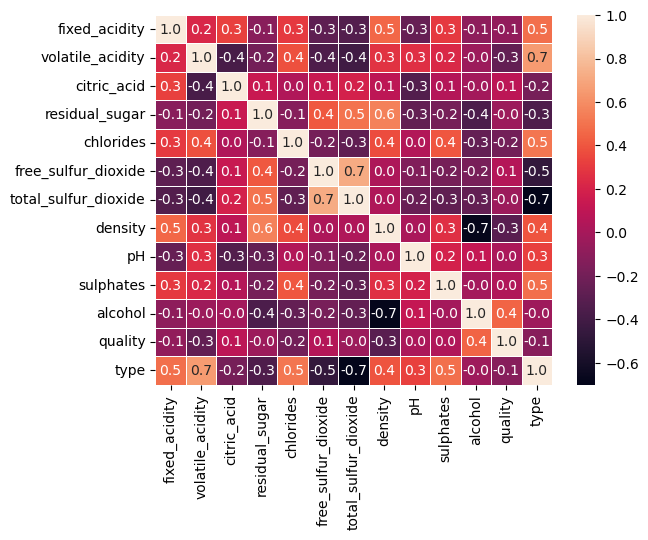

In [26]:
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".1f", linewidth=.5)

In [19]:
white_count, red_count = df['type'].value_counts()

red = df[df['type'] == 1]
white = df[df['type'] == 0]
white_smaller = white.sample(red_count)

# new dataset
balanced_data = pd.concat([white_smaller, red], axis=0)

X_train, X_test = train_test_split(df, train_size=0.8, test_size=0.2)

train_y = X_train['type'].values
train_X = X_train.drop(['type', 'quality'], axis=1).values

test_y = X_test['type'].values
test_X = X_test.drop(['type', 'quality'], axis=1).values

print('training:', X_train.shape, 'testing:', X_test.shape)
print('training y:', train_y.shape, 'training x:', train_X.shape)
print('testing y:', test_y.shape, 'testing x:', test_X.shape)

training: (5197, 13) testing: (1300, 13)
training y: (5197,) training x: (5197, 11)
testing y: (1300,) testing x: (1300, 11)


precision: 0.9114754098360656
recall:  0.86875
accuracy:  0.946923076923077
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       980
           1       0.91      0.87      0.89       320

    accuracy                           0.95      1300
   macro avg       0.93      0.92      0.93      1300
weighted avg       0.95      0.95      0.95      1300



<Figure size 640x480 with 0 Axes>

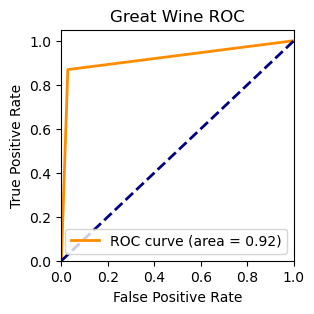

<Figure size 640x480 with 0 Axes>

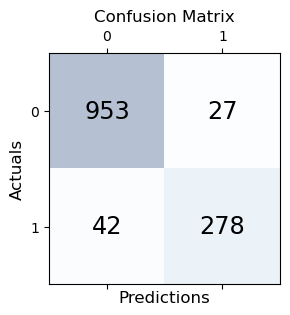

In [20]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(train_X, train_y)
yhat = clf.predict(test_X)

# metrics
print('precision:', precision_score(test_y, yhat))
print('recall: ', recall_score(test_y, yhat))
print('accuracy: ', accuracy_score(test_y, yhat))
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
roc_plot = plot_roc(roc_auc)
roc_plot.show()

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
mat = plot_conf_mat(conf_matrix)
mat.show()


precision: 0.9323843416370107
recall:  0.81875
accuracy:  0.9407692307692308
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.93      0.82      0.87       320

    accuracy                           0.94      1300
   macro avg       0.94      0.90      0.92      1300
weighted avg       0.94      0.94      0.94      1300



<Figure size 640x480 with 0 Axes>

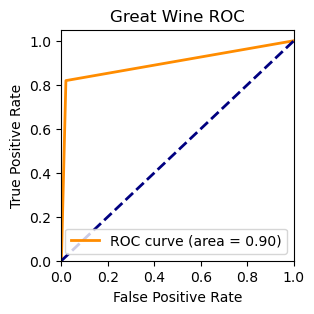

<Figure size 640x480 with 0 Axes>

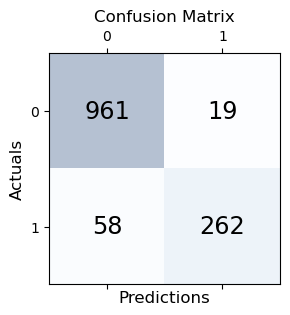

In [21]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(train_X, train_y)
yhat = clf.predict(test_X)

print('precision:', precision_score(test_y, yhat))
print('recall: ', recall_score(test_y, yhat))
print('accuracy: ', accuracy_score(test_y, yhat))
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
roc_plot = plot_roc(roc_auc)
roc_plot.show()

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
mat = plot_conf_mat(conf_matrix)
mat.show()

precision: 0.9450171821305842
recall:  0.859375
accuracy:  0.953076923076923
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.95      0.86      0.90       320

    accuracy                           0.95      1300
   macro avg       0.95      0.92      0.93      1300
weighted avg       0.95      0.95      0.95      1300



<Figure size 640x480 with 0 Axes>

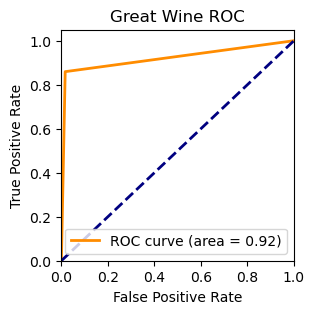

<Figure size 640x480 with 0 Axes>

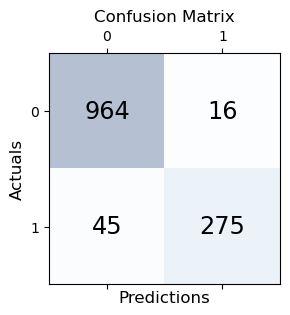

In [23]:
from sklearn.linear_model import Perceptron

clf = Perceptron()
clf.fit(train_X, train_y)
yhat = clf.predict(test_X)

print('precision:', precision_score(test_y, yhat))
print('recall: ', recall_score(test_y, yhat))
print('accuracy: ', accuracy_score(test_y, yhat))
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
roc_plot = plot_roc(roc_auc)
roc_plot.show()

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
mat = plot_conf_mat(conf_matrix)
mat.show()

precision: 0.978125
recall:  0.978125
accuracy:  0.9892307692307692
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.98      0.98      0.98       320

    accuracy                           0.99      1300
   macro avg       0.99      0.99      0.99      1300
weighted avg       0.99      0.99      0.99      1300



<Figure size 640x480 with 0 Axes>

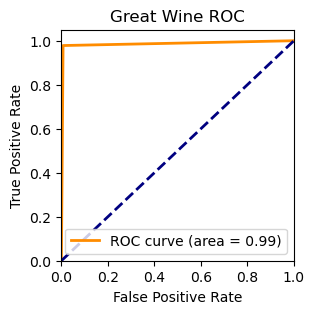

<Figure size 640x480 with 0 Axes>

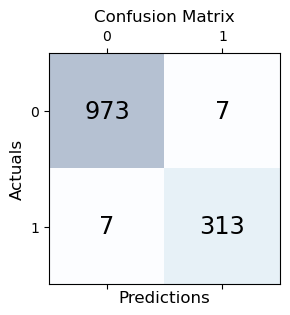

In [24]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(train_X, train_y)
yhat = clf.predict(test_X)

print('precision:', precision_score(test_y, yhat))
print('recall: ', recall_score(test_y, yhat))
print('accuracy: ', accuracy_score(test_y, yhat))
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
roc_plot = plot_roc(roc_auc)
roc_plot.show()

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
mat = plot_conf_mat(conf_matrix)
mat.show()

precision: 0.9936908517350158
recall:  0.984375
accuracy:  0.9946153846153846
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      0.98      0.99       320

    accuracy                           0.99      1300
   macro avg       0.99      0.99      0.99      1300
weighted avg       0.99      0.99      0.99      1300



<Figure size 640x480 with 0 Axes>

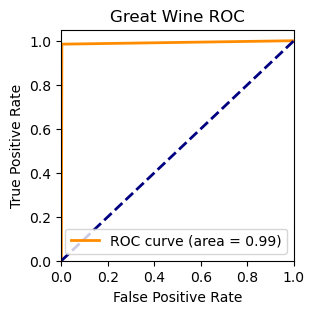

<Figure size 640x480 with 0 Axes>

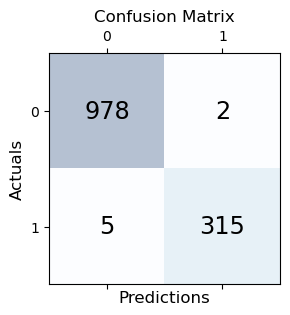

In [25]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(train_X, train_y)
yhat = clf.predict(test_X)

print('precision:', precision_score(test_y, yhat))
print('recall: ', recall_score(test_y, yhat))
print('accuracy: ', accuracy_score(test_y, yhat))
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
roc_plot = plot_roc(roc_auc)
roc_plot.show()

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
mat = plot_conf_mat(conf_matrix)
mat.show()

In [27]:
allowed_factors = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
    'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']

best = ['',0]
for p in allowed_factors:
    model  = smf.ols(formula='type ~ '+ p, data=X_train).fit()
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('best:',best)

best: ['total_sulfur_dioxide', 0.48676974744597945]


precision: 0.9714285714285714
recall:  0.95625
accuracy:  0.9823076923076923
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.97      0.96      0.96       320

    accuracy                           0.98      1300
   macro avg       0.98      0.97      0.98      1300
weighted avg       0.98      0.98      0.98      1300



/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Figure size 640x480 with 0 Axes>

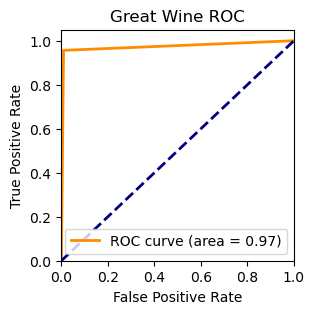

<Figure size 640x480 with 0 Axes>

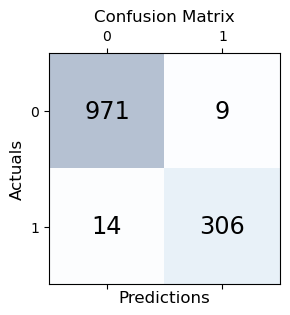

In [29]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(train_X, train_y)
yhat = clf.predict(test_X)

print('precision:', precision_score(test_y, yhat))
print('recall: ', recall_score(test_y, yhat))
print('accuracy: ', accuracy_score(test_y, yhat))
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
roc_plot = plot_roc(roc_auc)
roc_plot.show()

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
mat = plot_conf_mat(conf_matrix)
mat.show()